# Imports

In [ ]:
# automaticlly updates imported methods when they change
%load_ext autoreload
%autoreload 2

In [ ]:
# %%
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent.parent))
from IPython import get_ipython
from plots import plot_meas_vs_bb, plot_surface_fit
from tools import radius, fit_surface
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
import threading as th
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

---

# Load measurements

## Set path to the data

In [ ]:
path = Path().cwd()
while 'Multi' not in path.name:
    path = path.parent
PATH_TO_LOGS = path / 'data' / 'meas'

## Load

In [ ]:
def _loader(path):
    return str(path).split("\\")[-1], np.load(path)[2]

paths = list(PATH_TO_LOGS.glob('*.npy'))
with Pool(cpu_count()) as pool:
        loaded_data = list(tqdm(pool.imap(_loader, paths), desc='Loading data', total=len(paths)))
loaded_data = sorted(loaded_data, key=lambda x: x[0])

measurements = {}
with tqdm(total=len(loaded_data), desc='Parsing loaded data') as pbar:
    while loaded_data:
        name, image = loaded_data.pop()
        t_bb = int(name.split('_')[-1][:2])
        measurements.setdefault(t_bb, image.squeeze())
        pbar.update()
measurements = {k: measurements[k] for k in sorted(measurements)}
list_bb = list(measurements.keys())

In [ ]:
# get the random pixel across frames and temperature
import pandas as pd
import seaborn as sns


def plotNoiseAnalysis(data):
    pix_over_frames_disp = data.melt(
        var_name="temperature", value_name="grey_level", ignore_index=False)
    pix_over_frames_disp.index.rename("sample", inplace=True)
    pix_over_frames_disp.reset_index(level=0, inplace=True)
    sns_plot = sns.relplot(x="sample", y="grey_level", data=pix_over_frames_disp,
                col="temperature", col_wrap=4)
#     sns_plot.savefig('no_avg.png')


pix_idx = np.random.randint(low=[0, 0], high=measurements[list_bb[0]].shape[-2:], size=2)
meas = np.stack(list(measurements.values()))[:, 10:, ...]
pix_over_frames = pd.DataFrame(meas[..., pix_idx[0], pix_idx[1]].T, columns=list_bb)
plotNoiseAnalysis(pix_over_frames)
pix_over_frames.head()

del meas, pix_over_frames

In [ ]:
from sklearn.linear_model import LinearRegression
from IPython.display import display, Latex
import pandas as pd
import seaborn as sns

i,j = np.random.randint(low=[0, 0], high=measurements[list_bb[0]].shape[-2:], size=2)
meas = np.stack(list(measurements.values()))[:, 10:, ...]
regress_target_eg = meas[..., i, j].flatten()
x, y = np.array(list_bb).repeat(meas.shape[1])[:, np.newaxis], regress_target_eg[:, np.newaxis]
lr = LinearRegression().fit(x,y)
plt.figure(figsize=(16, 9))
res = sns.regplot(x=x, y=y, fit_reg=True)
plt.title(f"Regression model for random pixel {(i, j)}")
plt.xlabel("Temperature[C]")
plt.ylabel("Grey-Level")
plt.grid()

display(Latex(fr"Regression result: $GL = {lr.coef_.squeeze():.3f} \times T +{lr.intercept_.squeeze():.3f}$"))
display(Latex(fr"$R^2 = {lr.score(x, y):.3f}$"))

del meas, res, lr, regress_target_eg

---

In [40]:
path = Path('/home/navot/PycharmProjects/MultiSpectralCtrl/data/images/img1_good')
image = np.load(path.with_suffix('.npy'))
list_wavelength = list(pd.read_csv(path.with_suffix('.csv')).iloc[:, -1])
image.shape

(6, 100, 256, 336)

Random pixel (152, 149)


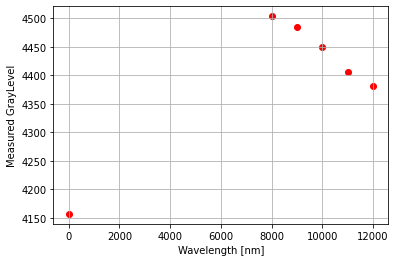

In [48]:
h, w = np.random.randint(low=[0, 0], high=image.shape[-2:], size=2)
print(f'Random pixel {h, w}')
plt.figure()
plt.scatter(list_wavelength, image.mean(1)[..., h,w], c='r')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Measured GrayLevel')
# plt.title(f'Measured vs BlackBody GT for $\lambda=${wl / 1000:.1f}' + '$_{\mu m}$')
plt.grid()
plt.show(block=False)
# plt.close()

---

In [ ]:
def _loader(path):
    return str(path).split("\\")[-1], np.load(path).mean(1)

paths = list(PATH_TO_LOGS.glob('*.npy'))
with Pool(cpu_count()) as pool:
        loaded_data = list(tqdm(pool.imap(_loader, paths), desc='Loading data', total=len(paths)))
loaded_data = sorted(loaded_data, key=lambda x: x[0])
list_wavelength = list(pd.read_csv(list(PATH_TO_LOGS.glob('*.csv'))[0]).iloc[:, 1])

In [ ]:
measurements = {}
with tqdm(total=len(loaded_data), desc='Parsing loaded data') as pbar:
    while loaded_data:
        name, image = loaded_data.pop()
        t_bb = int(name.split('_')[-1][:2])
        for wl, img in zip(list_wavelength, np.split(image, image.shape[0])):
            measurements.setdefault(wl, {}).setdefault(t_bb, img.squeeze())
        pbar.update()
for k, v in measurements.items():
    measurements[k] = {k: v[k] for k in sorted(v)}
measurements = {k: measurements[k] for k in sorted(measurements)}

list_bb = list(measurements[list_wavelength[0]].keys())
print(f'Measured {len(list_wavelength)} wavelength: {list_wavelength}nm, '
      f'at {len(list_bb)} BlackBody temperatures: {list_bb}C.')
print()
print('dict `measurments` has the wavelegnth as keys.')
print('Each values contains a dict with the blackbody temperatures as keys.')
print(
    'Each values of the sub-dict is np.ndarray with dimensions [h, w] for the respective wavelegnth and blackbody temperature.')

## Plot measurements

### Measurement VS BlackBody
Plots the maximal temperature in the measurements as a function of the Blackbody GT temperature.
The maximal temperature is selected under the assumption that there is the least amount of vignetting there.

In [ ]:
plot_meas_vs_bb(list_wavelength=list_wavelength, list_bb=list_bb, measurements=measurements)

---

# Temperature estimation based on grey-levels:
The relationship between the Black-Bodies radiance and the obtained grey-levels can be captured by the formula:
$$G_{i,j} = a_{i,j} \cdot P(\lambda_c, T)$$
Where:

* $G_{i,j}$ is the grey level of the i,jth pixel.
* $P(\lambda_c, T)$ is the black-body's radiance at the temperature $T$, after being filtered by a narrow band-pass with a central frequency $\lambda_c$. This term can be analytically solved for:
    $$P(\lambda_c, T) = \int_{\lambda_c-\frac{bw}{2}}^{\lambda_c+\frac{bw}{2}} B(\lambda, T) d\lambda$$ 
    where $B(\lambda, T) = \frac{2h/c^2\lambda^3}{exp(h/KT\lambda)-1}$, and $bw$ is the narrow band-pass band-width.
* $a_{i,j} are the scaling coefficients that translate the filtered radiance into grey-levels

Hence, to estimate the grey-levels, we should:
1. Estimate the black-body's radiance for the different temperature and filters.
2. Solve for the scaling coefficients.
3. Solve for the temperature (possibly be a LS solution to the primary equation above) 

## Estimate the black-body radiance coefficients per temperature and central frequency:
To estimate the Black-bodies radiance, we need to calculate the integral presented above:
$$P(\lambda_c, T) = \int_{\lambda_c-\frac{bw}{2}}^{\lambda_c+\frac{bw}{2}} B(\lambda, T) d\lambda$$ 

However, as our data is acquired using real-world filters (and not ideal ones), the non-optimal transmitance needs to be acounted for. Threfore, the actual radiance received by the sensor is:
$$P(\lambda_c, T) = \int_{\lambda_c-\frac{bw}{2}}^{\lambda_c+\frac{bw}{2}} B(\lambda, T)\cdot F(\lambda) d\lambda$$ 
where $F(\lambda)$ is the frequency response of our narrow band-pass IR filter.

The function ***calcRxPower*** acounts for these non-optimalities, and calculates the actual received radiance according to the temperature and central frequency. To do so, it looks for the frequency response of the relevant filter in a static xlsx table containing Thorlab's characterizations for each filter.

Along is an example of how the function works at $T=32[C]$, $\lambda_c=9000[nm]$: 


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["font.size"] = 14
matplotlib.rcParams["figure.figsize"] = (19, 10)
from tools import calcRxPower
rx_power = calcRxPower(32, 9000, debug=True)


With that functionality in hand, let's now calculate the received radiance for each set point of temperature and filter:

In [ ]:
# %% 
import pandas as pd
c_wls = measurements.keys()  # list of central wavelengths
temperatures = measurements[list(c_wls)[0]].keys()
plank_coeefs = pd.DataFrame(index=temperatures, columns=c_wls)
for c_wl in c_wls:
    for temp in temperatures:
        plank_coeefs.loc[temp, c_wl] = calcRxPower(temp, c_wl)

plt.figure()
plank_coeefs.plot(style='-o')
plt.title("$P(\lambda, T)$ Vs Temperature")
plt.ylabel("$P(\lambda, T)$")
plt.xlabel("Black-Body Temperature[C]")
plt.grid()


## Solve for the per-pixel scaling factors ($a_{i,j}$)    

### 1st approach: normalize grey levels by $P(\lambda, T)$ and average over all samples

In [ ]:
# Averaging an Normalizing:
chunk_shape = image.shape
all_frames_aligned = np.zeros(shape=[len(c_wls)*len(temperatures), *chunk_shape[1:]])
for i, c_wl in enumerate(c_wls):
    for j, temp in enumerate(temperatures):
        all_frames_aligned[i*len(temperatures)+j, ...] = measurements[c_wl][temp].mean(axis=0) / plank_coeefs.loc[temp, c_wl]

a_ij = all_frames_aligned.mean(axis=0)


In [ ]:
plt.figure()
plt.imshow(a_ij, cmap="gray")
plt.title("scaling factors $a_{i,j}$")

#### Validate Results:
We will validate by normalizing an average frame at a given temperature and central frequency by the scaling coefficients. We expect to obtain a roughly constant result, which reflects the spectral radiance at this temperature and central frequency:

$$G_{i,j} = a_{i,j} \cdot P(\lambda_c, T) \Rightarrow \frac{G_{i,j}}{a_{i,j}} = P(\lambda_c, T)$$

In [ ]:
arbitrary_frame = measurements[c_wl][temp].mean(axis=0)
radiometric_range = arbitrary_frame.ptp()
frame_center = np.mean([arbitrary_frame.min(), arbitrary_frame.max()])
P_hat = arbitrary_frame / a_ij
P_hat_center = np.mean([P_hat.min(), P_hat.max()])
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(arbitrary_frame, cmap="gray")
ax[0, 0].set_title("$G_{i,j}$")
ax[0, 1].imshow(P_hat - P_hat_center, vmin=-radiometric_range/2, vmax=radiometric_range, cmap="gray")
ax[0, 1].set_title("$\\frac{G_{i,j}}{a_{i,j}} (=P(\lambda_c, T))$")
ax[1, 0].hist(arbitrary_frame.flatten())
ax[1, 0].set_title("$G_{i,j}$ Hist " + f"(std={arbitrary_frame.std():.2e})")
ax[1, 1].hist(P_hat.flatten())
ax[1, 1].set_title("$\\frac{G_{i,j}}{a_{i,j}}" + f"(=P(\lambda_c, T))$ Hist (std={P_hat.std():.2e})")

fig.tight_layout()
